In [211]:
import pandas as pd
import numpy as np

# Different possible regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

# Other process packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
# import statsmodels

# Model scoring and assessment packages
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import root_mean_squared_error

# Model optimization packages
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Visualization packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

Helper functions

In [147]:
def plot_permutation_importance(clf,
                                X,
                                y,
                                scoring,
                                random_state,
                                ax):
    '''
    
    '''
    result = permutation_importance(clf,
        X,
        y,
        scoring=scoring,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel(scoring)

    fig.tight_layout()
    plt.show()

    return ax

def display_feature_importance(clf,
                               X_train,
                               X_test,
                               y_train,
                               y_test):
    '''
    
    '''

    results = pd.Series(
        clf.feature_importances_,
        index=clf.feature_names_in_,
        ).sort_values(ascending=False)
    print("Feature Importance Ranking:\n", results.index)
    results.plot.bar(figsize=(15, 5))
    r = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{clf.feature_names_in_[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini Importance")
    plot_permutation_importance(clf, X_train, y_train, "neg_root_mean_squared_error", 42, ax2)
    ax2.set_xlabel("Decrease in neg_root_mean_squared_error")
    # fig.subtitle(
    #     "Impurity-based Feature Importance vs Permutation Importances /n on multicolinear features (train set)")
    _ = fig.tight_layout()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_permutation_importance(clf, X_test, y_test, "neg_root_mean_squared_error", 42, ax)
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel("Decrease in neg_root_mean_squared_error")
    _ = ax.figure.tight_layout()
    plt.show()

Read in the main dataset and drop unnecessary columns.

In [148]:
df = pd.read_csv('final_merge.csv',
    index_col=0)
print(f'Dataframe shape: {df.shape}')
print(f'dataframe columns: {df.columns}')

# Drop columns with percentages
df = df[df.columns.drop(list(df.filter(regex='Percent')))]


Dataframe shape: (1730, 54)
dataframe columns: Index(['disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Percent!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2

Review the dataframe.

In [149]:
df.head()

,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Name,Date_y,Latitude,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,1147,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,87.175749
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,1384,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,349.863220
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,1766,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,63.975663
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,333,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,111.469171
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,2457,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,72.859249


In [150]:
df.describe()

,disasterNumber,fipsStateCode,fipsCountyCode,year,validReg_own,DamageBetween1and1000,DamageBetween10001and2000,DamageBetween20001and3000,DamageGreaterThan3000,validReg_rent,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Date_y,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
count,1730.000000,1730.000000,1730.000000,1730.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1689.000000,...,1730.000000,1730.000000,1730.000000,1730.000000,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000
mean,3094.516763,31.530636,108.391908,2012.023699,6090.835960,1841.802685,155.615295,53.805604,66.267951,4555.212552,...,7281.291908,4995.699422,2400.882081,2139.339306,2.012114e+07,97.234104,953.211561,28.673815,-82.800289,236.829505
std,1458.354903,20.591525,119.229293,7.755594,17289.765569,5212.056569,784.883876,372.534664,511.160118,19365.789881,...,16648.966254,12298.887890,6137.119990,5229.259202,7.756742e+04,19.661540,17.364006,4.368017,7.763506,250.074421
min,1479.000000,1.000000,1.000000,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,39.000000,41.000000,-71.000000,-61.000000,2.003072e+07,65.000000,919.000000,18.000000,-97.200000,4.543943
25%,1554.000000,12.000000,43.000000,2004.000000,324.000000,138.000000,2.000000,0.000000,0.000000,106.000000,...,1129.750000,709.250000,357.250000,371.000000,2.004092e+07,80.000000,939.000000,27.200000,-87.900000,81.909737
50%,4019.000000,28.000000,83.000000,2011.000000,1359.000000,464.000000,15.000000,2.000000,2.000000,581.000000,...,2273.000000,1424.500000,768.000000,790.500000,2.011083e+07,95.000000,952.000000,29.300000,-82.200000,152.902961
75%,4400.000000,48.000000,123.000000,2018.000000,4862.000000,1434.000000,73.000000,13.000000,13.000000,2471.000000,...,5992.000000,3657.750000,1880.500000,1896.250000,2.018101e+07,110.000000,965.000000,30.200000,-79.500000,270.123505
max,4834.000000,72.000000,840.000000,2024.000000,331674.000000,99520.000000,23576.000000,11003.000000,11077.000000,374677.000000,...,240198.000000,145008.000000,99878.000000,63843.000000,2.024101e+07,140.000000,986.000000,34.900000,-65.900000,1312.120049


Merge this dataset with storm information about the closest pass for each observation.

In [151]:
# Rename one column to make merging easier.
df['declarationTitle'].rename('Name')

# Remove HURRICANE from all hurricane names for merging purposes.
df['Name'] = df['Name'].str.replace('HURRICANE ', '')
df.columns

Index(['disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'E

In [152]:
# Load the data to be merged and rename columns to be more specific.
df_closest_pass = pd.read_csv('closest_pass.csv')
df_closest_pass.rename(columns={'Max Wind':'Closest_Max_Wind', 
                                'Max Pressure':'Closest_Max_Pressure'}, inplace=True)
df_closest_pass.head()


,Name,year,Closest_Max_Wind,Closest_Max_Pressure,fipsCode,distance_from_storm,category
0,BERYL,2024,70,978,48015,40.192025,TS
1,BERYL,2024,25,1004,48037,6.349638,TD
2,BERYL,2024,70,978,48039,37.310013,TS
3,BERYL,2024,50,988,48071,79.163470,TS
4,BERYL,2024,70,978,48157,29.248125,TS


In [153]:
# Merge the original dataframe with the closest pass storm information for each observation.
df = pd.merge(left=df, right=df_closest_pass, on=['Name', 'year', 'fipsCode'])
df.head()

,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,96.0W,80,978,28.6,-96.0,87.175749,70,978,40.192025,TS
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,96.0W,80,978,28.6,-96.0,349.863220,25,1004,6.349638,TD
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,96.0W,80,978,28.6,-96.0,63.975663,70,978,37.310013,TS
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,96.0W,80,978,28.6,-96.0,111.469171,50,988,79.163470,TS
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,96.0W,80,978,28.6,-96.0,72.859249,70,978,29.248125,TS


Perform a similar process to add county-level cluster information to our main dataframe by merging on fipsCode

In [154]:
df_clusters = pd.read_csv('clusters.csv',
    index_col=0)
df_clusters.head()


,fipsCode,housing_cluster,econ_cluster
0,48015,0,3
1,48015,0,3
2,48015,0,3
3,48037,0,0
4,48039,2,3


In [155]:
# Merge the original dataframe with the closest pass storm information for each observation.
df = pd.merge(left=df, right=df_clusters, on=['fipsCode'])
df.head()

,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category,housing_cluster,econ_cluster
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,978,28.6,-96.0,87.175749,70,978,40.192025,TS,0,3
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,978,28.6,-96.0,87.175749,70,978,40.192025,TS,0,3
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,978,28.6,-96.0,87.175749,70,978,40.192025,TS,0,3
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,978,28.6,-96.0,349.863220,25,1004,6.349638,TD,0,0
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,978,28.6,-96.0,63.975663,70,978,37.310013,TS,2,3


In [156]:
# Create dependent variable as sum of "damage" columns (replacing Nan values with 0)
df['Damage'] = df['DamageBetween20001and3000'].fillna(0) + df['DamageGreaterThan3000'].fillna(0) + df['MajorDamage_rent'].fillna(0)
df['lnDamage'] = np.log(df['Damage']
                        + 1)  # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)

# # Delete original "damage" columns
# df = df.drop(df.columns[0:3], axis=1)

# # Move dependent variable to first column position
# col = df.pop('lnDamage')
# df.insert(0, 'lnDamage', col)
# col = df.pop('Damage')
# df.insert(0, 'Damage', col)

df = df[
    ['Damage',
    'lnDamage',
    'disasterNumber',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    'Max Wind',
    'Max Pressure',
    'dist_from_landfall',
    'Closest_Max_Wind',
    'Closest_Max_Pressure',
    'distance_from_storm',
    'category',
    'housing_cluster',
    'econ_cluster'
    ]
]

print(f'Count NaN values: {df.isna().any()}') # Damage column has Nan values initially


df.describe()

Count NaN values: Damage                                                                        False
lnDamage                                                                      False
disasterNumber                                                                False
Estimate!!HOUSING OCCUPANCY!!Total housing units                              False
Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built

,Damage,lnDamage,disasterNumber,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Max Wind,Max Pressure,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,housing_cluster,econ_cluster
count,6490.000000,6490.000000,6490.000000,6.490000e+03,6.490000e+03,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,...,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000
mean,217.862866,2.773742,3162.337134,9.283414e+04,7.732702e+04,760.271032,5004.448690,13959.396456,15115.751772,17597.240832,...,3085.143297,2834.794607,97.893683,953.111864,213.838593,77.330508,963.746687,84.519530,0.525116,1.568413
std,1109.160894,2.113212,1455.091984,1.523208e+05,1.312451e+05,2761.810610,15987.581984,25419.435274,23087.235992,29116.638077,...,6607.013828,6484.402472,19.071556,16.439416,232.551337,25.264897,19.480127,105.667171,0.864926,1.405476
min,0.000000,0.000000,1479.000000,2.334000e+03,1.386000e+03,0.000000,0.000000,49.000000,138.000000,154.000000,...,-71.000000,-61.000000,65.000000,919.000000,4.543943,20.000000,919.000000,3.563970,0.000000,0.000000
25%,2.000000,1.098612,1561.000000,1.240325e+04,9.616000e+03,0.000000,0.000000,1350.000000,2043.000000,2214.500000,...,431.000000,417.000000,80.000000,941.000000,76.763811,60.000000,948.000000,34.895796,0.000000,0.000000
50%,12.000000,2.564949,4080.000000,3.068500e+04,2.609700e+04,0.000000,91.000000,3916.000000,5057.000000,5088.000000,...,1003.000000,1036.000000,100.000000,952.000000,140.783924,75.000000,967.000000,56.599276,0.000000,2.000000
75%,62.000000,4.143135,4570.000000,1.108120e+05,8.999700e+04,14.000000,1960.000000,16667.000000,18365.000000,20531.000000,...,2482.000000,2315.000000,110.000000,960.000000,238.176520,100.000000,978.000000,98.131680,1.000000,3.000000
max,21555.000000,9.978409,4834.000000,1.942862e+06,1.789470e+06,48370.000000,343520.000000,341119.000000,222934.000000,297831.000000,...,99878.000000,63843.000000,140.000000,986.000000,1312.120049,140.000000,1007.000000,1000.000000,4.000000,4.000000


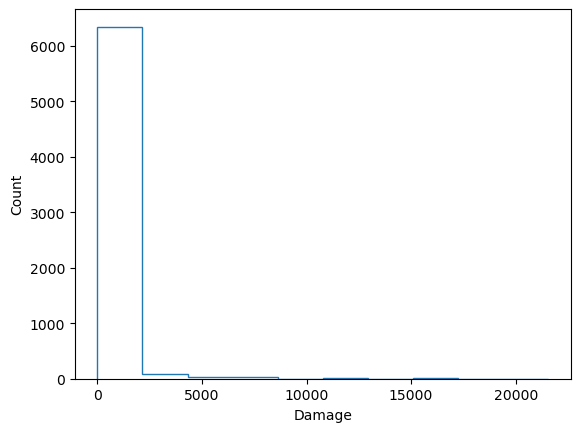

In [157]:
# Plot the dependent variable, 'Damage'

counts, bins = np.histogram(df['Damage'])
plt.stairs(counts, bins)
plt.xlabel('Damage')
plt.ylabel('Count')
plt.show()

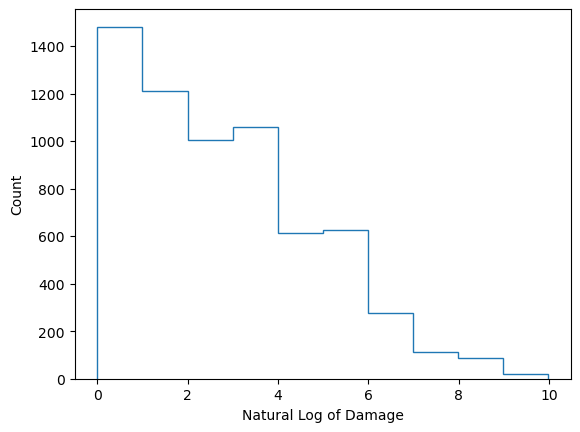

In [158]:
# Plot the dependent variable, 'Damage'

counts, bins = np.histogram(df['lnDamage'])
plt.stairs(counts, bins)
plt.xlabel('Natural Log of Damage')
plt.ylabel('Count')
plt.show()

Engineer a few additional features by combining some of the existing features.

In [159]:
# Factor distance from landfall into the maximum storm windspeed for counties further away from the strongest part of the storm
df['wind_speed_div_distance'] = df['Max Wind'] / df['dist_from_landfall']

Identify the quantitative and categorical features.

In [160]:
categories = [
    'category',
    'housing_cluster',
    'econ_cluster'
]
print(categories)

quants = [x for x in df.columns.tolist() if x not in categories]
quants.remove('Damage')
quants.remove('lnDamage')
quants.remove('disasterNumber')

quants

['category', 'housing_cluster', 'econ_cluster']


['Estimate!!HOUSING OCCUPANCY!!Total housing units',
 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
 'Max Wind',
 'Max Pressure',
 'dist_from_landfall',
 'Closest_Max_Wind',
 'Closest_Max_Pressure',
 'dista

In [161]:
# Split the dataset into features and target subsets
X = df.drop(['Damage','lnDamage'], axis=1)
y = df['lnDamage'] # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)
y_ = df['Damage']

In [181]:
preprocessor = ColumnTransformer(
    transformers=[
        ('quant', Normalizer(), quants),
        ('cat', OneHotEncoder(sparse_output=False).set_output(transform='pandas'), categories)
    ]
).set_output(transform='pandas')
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                # ('regressor', RandomForestRegressor(random_state=0)),
                ])



In [ ]:
# # Scale the dataframe
# scaler = Normalizer()
# scaled_data = scaler.fit_transform(df)
# scaled_df = pd.DataFrame(scaled_data,
#                          columns=df.columns)

# # df = pd.get_dummies(df,
# #                columns=['category'],
# #                dtype=int)
# # df.head()

In [215]:
lr_clf = LinearRegression()
br_clf = BayesianRidge()
rf_clf = RandomForestRegressor(random_state=0)
SVR_clf = SVR(kernel='rbf')
gbr_clf = GradientBoostingRegressor(random_state=0)
hgbr_clf = HistGradientBoostingRegressor(random_state=0)
bgr_clf = BaggingRegressor(random_state=0)
mlpr_clf = MLPRegressor(max_iter=500,
    random_state=0)
dummy_clf = DummyRegressor()
clf_list = [lr_clf,
            br_clf,
            rf_clf,
            SVR_clf,
            gbr_clf,
            hgbr_clf,
            bgr_clf,
            mlpr_clf,
            dummy_clf,
            ]

X_ = X.drop(['disasterNumber'], axis=1)
X__ = pipe.fit_transform(X_)

for clf in clf_list:
    cross_val_results = cross_val_score(clf, X__, y, cv=5, scoring='r2')

    print(f'{clf} Mean: {cross_val_results.mean()}')
    print(f'{clf} Standard Deviation: {cross_val_results.std()}')


LinearRegression() Mean: 0.050943917251436696
LinearRegression() Standard Deviation: 0.14715141665993836
BayesianRidge() Mean: 0.03747232356186871
BayesianRidge() Standard Deviation: 0.15079518286444824
RandomForestRegressor(random_state=0) Mean: 0.1333301451513517
RandomForestRegressor(random_state=0) Standard Deviation: 0.13410455663490542
SVR() Mean: -0.1341112215956569
SVR() Standard Deviation: 0.1339233915985442
GradientBoostingRegressor(random_state=0) Mean: 0.1740559995268208
GradientBoostingRegressor(random_state=0) Standard Deviation: 0.11696228928727966
HistGradientBoostingRegressor(random_state=0) Mean: 0.10149835008772556
HistGradientBoostingRegressor(random_state=0) Standard Deviation: 0.1383235798309721
BaggingRegressor(random_state=0) Mean: 0.0955211298098034
BaggingRegressor(random_state=0) Standard Deviation: 0.1388570630176152


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

MLPRegressor(max_iter=500, random_state=0) Mean: -0.09430692970719554
MLPRegressor(max_iter=500, random_state=0) Standard Deviation: 0.20079750305197716
DummyRegressor() Mean: -0.04467814828648007
DummyRegressor() Standard Deviation: 0.06098156791971539


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


The results are very disappointing. This could be caused in part to the high number of low/no damage entries, which is primarily tied to storm strength. This is measured by the feature 'category'.

Stratifying on storm category as we want to have an better spread of damages in each fold for better training results.

In [216]:
groups = X['category'].astype(str)
skfold = StratifiedKFold(n_splits=10,
                         shuffle=True,
                         random_state=0)

for clf in clf_list:
    cross_val_results = cross_val_score(clf,
                                        X__,
                                        y,
                                        cv=skfold.split(X__, groups),
                                        scoring='r2',
                                        )

    print(f'{clf} Mean: {cross_val_results.mean()}')
    print(f'{clf} Standard Deviation: {cross_val_results.std()}')


LinearRegression() Mean: 0.271511672083646
LinearRegression() Standard Deviation: 0.025584885564277113
BayesianRidge() Mean: 0.255294360203038
BayesianRidge() Standard Deviation: 0.030961146357329404
RandomForestRegressor(random_state=0) Mean: 0.9698986016617501
RandomForestRegressor(random_state=0) Standard Deviation: 0.008099252054031112
SVR() Mean: 0.255038522186246
SVR() Standard Deviation: 0.034210442696755654
GradientBoostingRegressor(random_state=0) Mean: 0.638858894104507
GradientBoostingRegressor(random_state=0) Standard Deviation: 0.019105447487401735
HistGradientBoostingRegressor(random_state=0) Mean: 0.9044649477104467
HistGradientBoostingRegressor(random_state=0) Standard Deviation: 0.007293846190626214
BaggingRegressor(random_state=0) Mean: 0.9617438842390541
BaggingRegressor(random_state=0) Standard Deviation: 0.006413189067901708


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

MLPRegressor(max_iter=500, random_state=0) Mean: 0.5243065979280419
MLPRegressor(max_iter=500, random_state=0) Standard Deviation: 0.023952319591592434
DummyRegressor() Mean: -0.0017385443176321847
DummyRegressor() Standard Deviation: 0.0015568473869941083


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#pipe_linreg = Pipeline([('scaler', StandardScaler()), ('algorithm', LinearRegression())])
X_train_, X_test_, y_train, y_test = train_test_split(X_,y,test_size=0.2, random_state=50)
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

lr_clf = LinearRegression().fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_score = lr_clf.score(X_test, y_test)

br_clf = BayesianRidge().fit(X_train, y_train)
br_preds = br_clf.predict(X_test)
br_score = br_clf.score(X_test, y_test)

rf_clf = RandomForestRegressor(random_state=0).fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
rf_score = rf_clf.score(X_test, y_test)

SVR_clf = SVR(kernel='rbf').fit(X_train, y_train)
SVR_preds = SVR_clf.predict(X_test)
SVR_score = SVR_clf.score(X_test, y_test)

gbr_clf = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
gbr_preds = gbr_clf.predict(X_test)
gbr_score = gbr_clf.score(X_test, y_test)

print(f'Linear Regression Score: {lr_score}')
print(f'Bayesian Ridge Score: {br_score}')
print(f'Random Forest Score: {rf_score}')
print(f'SVR Score: {SVR_score}')
print(f'Gradient Boosting Regressor Score: {gbr_score}')


Linear Regression Score: 0.29752645917695075
Bayesian Ridge Score: 0.2786817228830405
Random Forest Score: 0.9641993190530868
SVR Score: 0.27282305271120433
Gradient Boosting Regressor Score: 0.6584375064446188


In [183]:
# Model metrics for random forest model
print(f'Score: {rf_clf.score(X_test, y_test)}')
print(f'R2 Score: {r2_score(y_test, rf_preds)}')
print(f'MSE: {mean_squared_error(y_test, rf_preds)}')
print(f'MAE: {mean_absolute_error(y_test, rf_preds)}')
print(f'Median Absolute Error: {median_absolute_error(y_test, rf_preds)}')
print(f'RMSE: {root_mean_squared_error(y_test, rf_preds)}')
print(f'Cross Validation Score: {cross_val_score(rf_clf, X_train, y_train, cv=5).mean()}')

Score: 0.9641993190530868
R2 Score: 0.9641993190530868
MSE: 0.15563096953641942
MAE: 0.17848066030544807
Median Absolute Error: 0.03538397285650863
RMSE: 0.39450091195891984
Cross Validation Score: 0.9401122685961306


In [18]:
# param_dist = {
#     "learning_rate": stats.uniform(0, 1),
#     "subsample": stats.uniform(0, 1),
#     "max_depth": stats.randint(1, 20),
#     "n_estimators": stats.randint(50, 150),
#     "max_features": stats.uniform(0, 1),
#     "loss": ["ls", "lad", "huber", "quantile"],
# }

# clf = GradientBoostingRegressor(random_state=0)

# n_iter_search = 50
# random_search_gbr = RandomizedSearchCV(
#     clf, 
#     param_distributions=param_dist, 
#     n_iter=n_iter_search, 
#     random_state=0,
#     cv = groupkfold,
#     scoring='r2',
#     return_train_score=True,
# )

# random_search_gbr.fit(X_train, y_train, groups=groups)

# best_model_gbr = random_search_gbr.best_estimator_
# best_model_gbr.fit(X_train, y_train)
# print(random_search_gbr.best_params_)


In [19]:
# gbr_preds = best_model_gbr.predict(X_test)
# gbr_score = best_model_gbr.score(X_test, y_test)
# print(f'Gradient Boosting Regressor Score: {gbr_score}')


In [196]:
param_dist = {
    "max_depth": stats.randint(5, 30),
    "n_estimators": stats.randint(50, 150),
    "max_features": stats.uniform(.5, 1),
    # "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    # "min_samples_split": stats.uniform(0, 1),
    # "min_samples_leaf": stats.uniform(0, 1),
}

clf = RandomForestRegressor(random_state=0)

# n_iter_search = 50
# random_search_rfr = RandomizedSearchCV(
#     clf, param_distributions=param_dist, n_iter=n_iter_search, random_state=0
# )

n_iter_search = 35
random_search_rfr = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    random_state=0,
    cv = 5,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1
)

random_search_rfr.fit(X_train, y_train,)


print(random_search_rfr.best_params_)
best_model_rfr = random_search_rfr.best_estimator_
best_model_rfr.fit(X_train, y_train)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
110 fits failed out of a total of 175.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Use

{'max_depth': 28, 'max_features': np.float64(0.8380076148388917), 'n_estimators': 135}


RandomForestRegressor(max_depth=28, max_features=np.float64(0.8380076148388917),
                      n_estimators=135, random_state=0)

In [194]:
training_scores = random_search_rfr.cv_results_
training_scores['mean_test_score']

array([       nan,        nan,        nan, 0.86681743,        nan,
              nan, 0.93388155, 0.93785973,        nan,        nan,
              nan,        nan,        nan, 0.74373801, 0.68055656,
              nan,        nan,        nan,        nan, 0.93348401,
              nan, 0.92107638, 0.86236063,        nan, 0.93597856])

In [195]:
rfr_preds = best_model_rfr.predict(X_test)
rfr_score = best_model_rfr.score(X_test, y_test)
print(f'Random Forest Regressor Score: {rfr_score}')

rfr_preds = rf_clf.predict(X_test)
rfr_score = rf_clf.score(X_test, y_test)
print(f'Random Forest Regressor Score: {rfr_score}')

Random Forest Regressor Score: 0.9715445027610299
Random Forest Regressor Score: 0.9716616999387117


In [187]:
states = list(range(1,11))
score_list = []
for i in states:
    X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=i,
                                                        )

    pipe.fit(X_train_)
    X_train = pipe.transform(X_train_)
    X_test = pipe.transform(X_test_)
    rf_clf.fit(X_train, y_train)
    score_list.append(rf_clf.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

[0.9563544652436045, 0.9588821991149832, 0.9755010897888734, 0.9626271792748955, 0.9580039153985462, 0.9642309661580362, 0.9645085852350258, 0.9667128119411832, 0.9633054985301279, 0.9716616999387117]
0.9641788410623988
0.005668282907150157


In [197]:
states = list(range(1,11))
score_list = []
for i in states:
    X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=i,
                                                        )

    pipe.fit(X_train_)
    X_train = pipe.transform(X_train_)
    X_test = pipe.transform(X_test_)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

[0.9582935253853426, 0.960843491578204, 0.97676209347837, 0.9639051302667052, 0.9592658464118514, 0.9648517807522172, 0.9658169347392112, 0.9680635694011341, 0.9629726935759533, 0.971197697209633]
0.9651972762798622
0.005356178821129851


/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_44660/3940206906.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


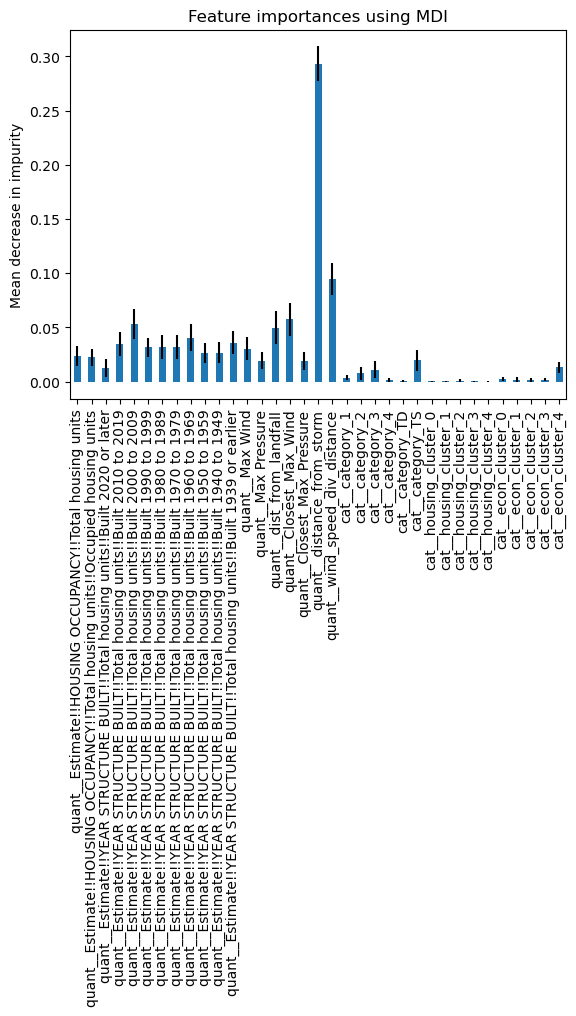

In [198]:
importances = rf_clf.feature_importances_
feature_names = [i for i in X__.columns]
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

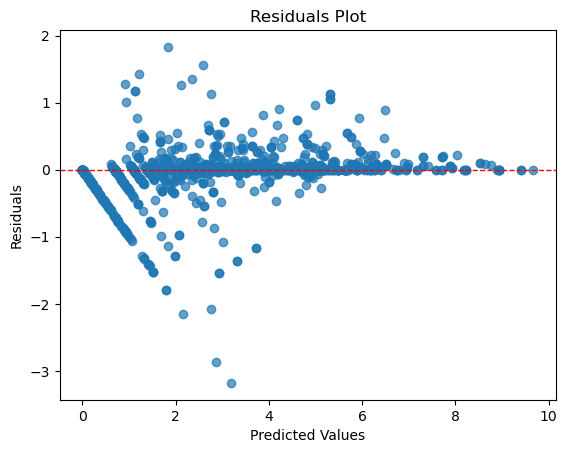

In [199]:
y_pred = rf_clf.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

Feature Importance Ranking:
 Index(['quant__distance_from_storm', 'quant__wind_speed_div_distance',
       'quant__Closest_Max_Wind',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'quant__dist_from_landfall',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'quant__Max Wind',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',


/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_44660/1961396358.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[perm_sorted_idx].T,
/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_44660/1961396358.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


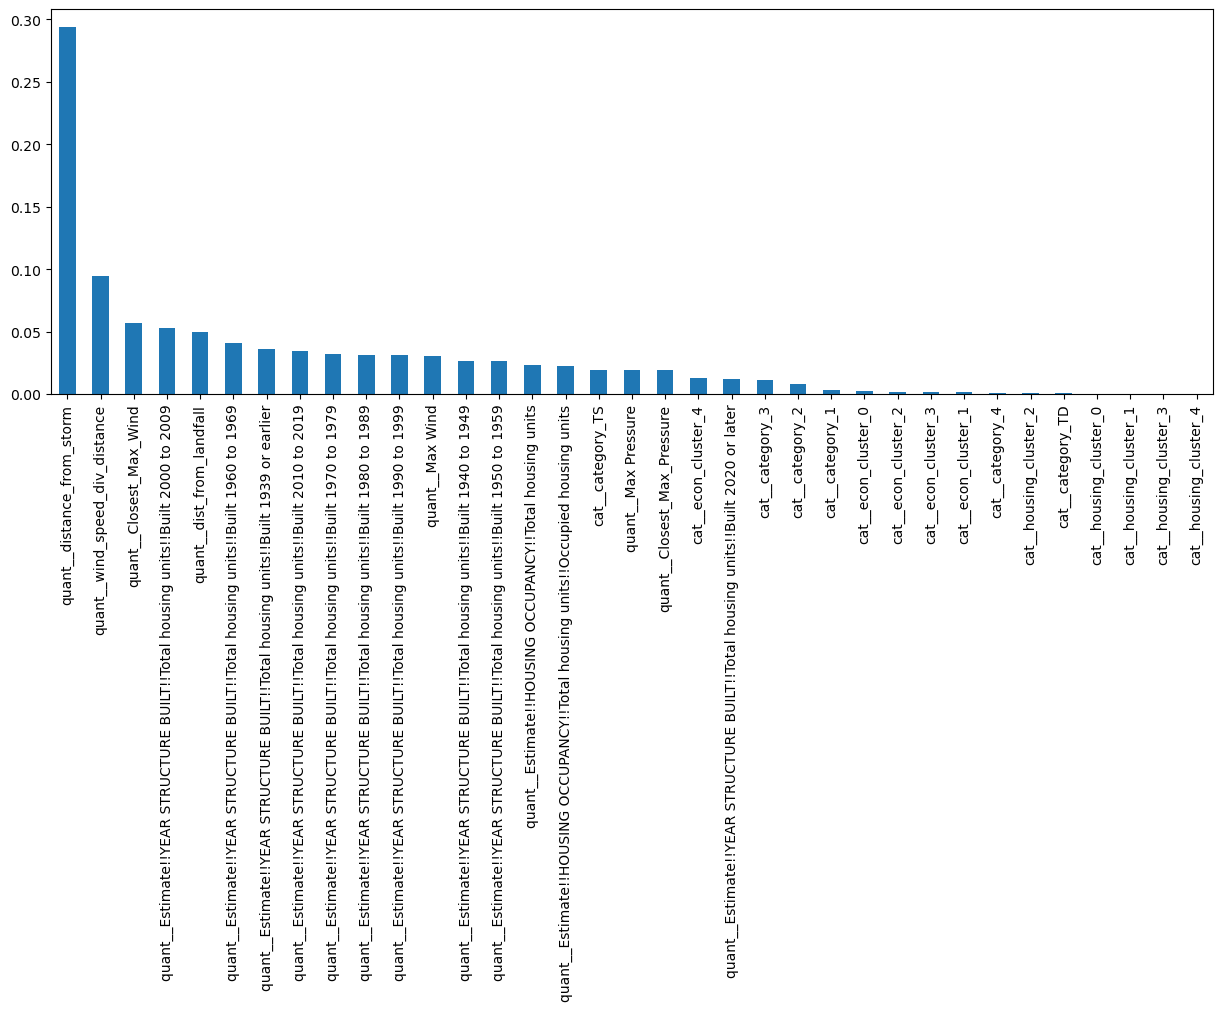

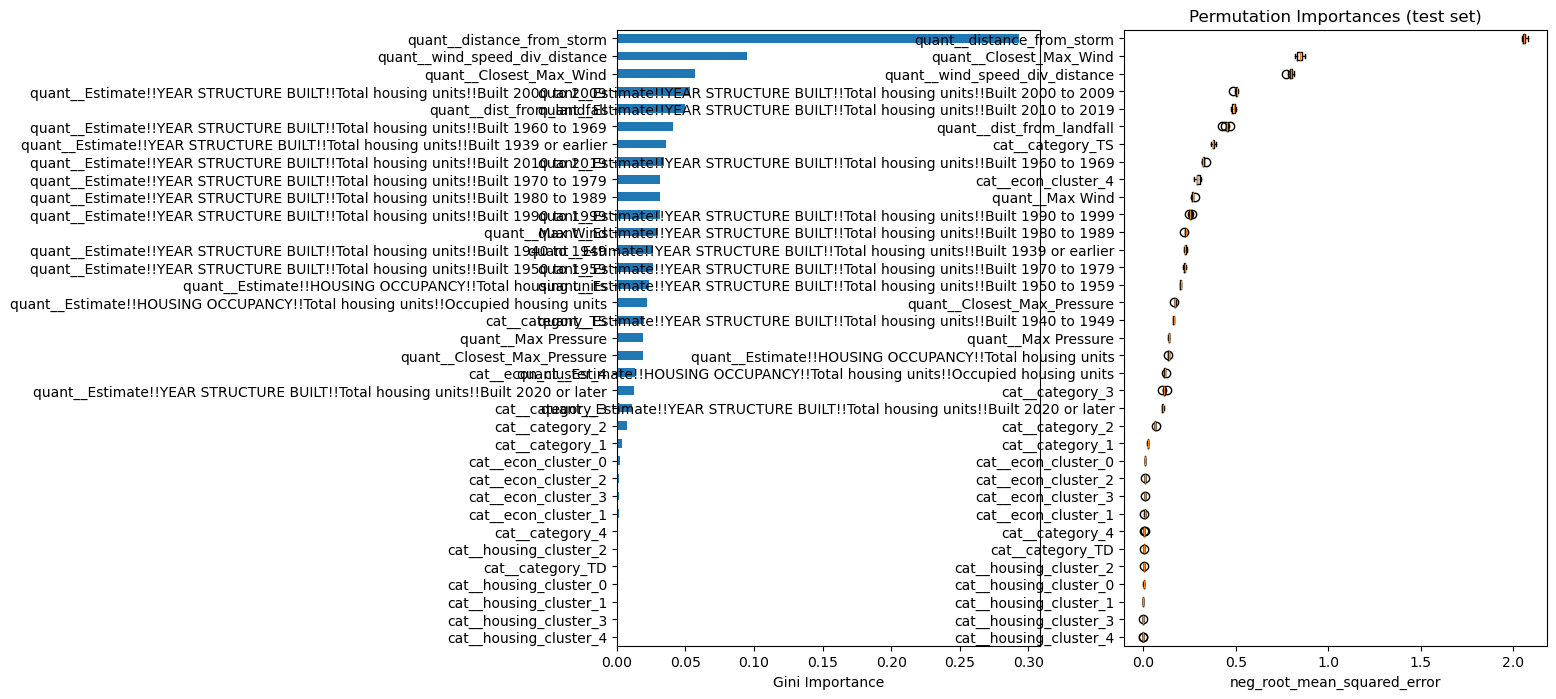

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_44660/1961396358.py:59: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  _ = fig.tight_layout()
/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_44660/1961396358.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[perm_sorted_idx].T,
/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_44660/1961396358.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


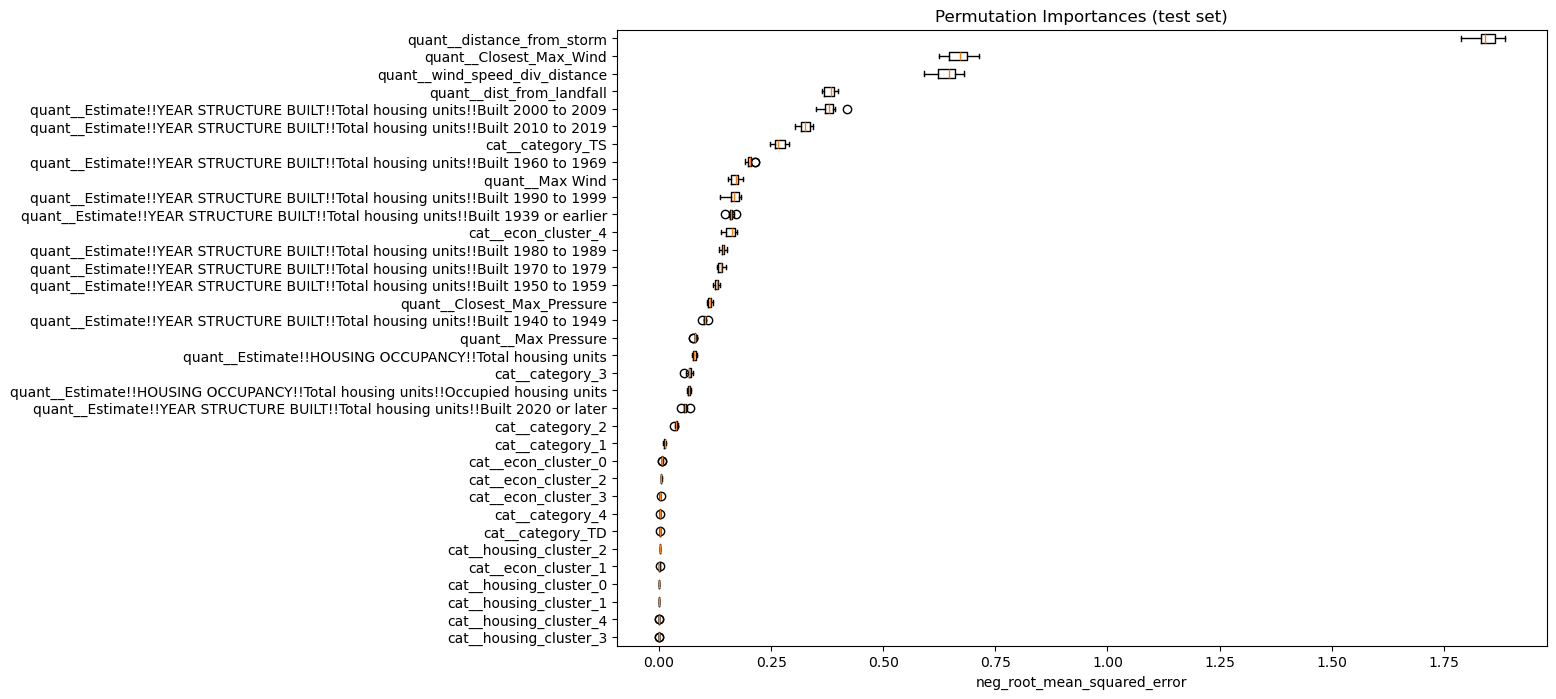

In [200]:
display_feature_importance(rf_clf,
                           X_train,
                           X_test,
                           y_train,
                           y_test)

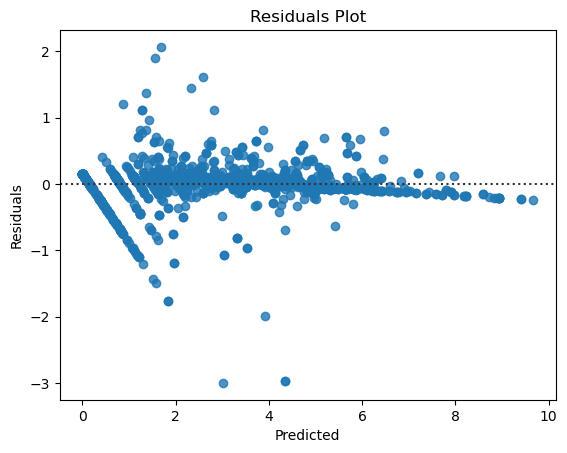

In [81]:
residuals_df = pd.DataFrame({'Predicted': y_pred, 'Residuals': residuals})

# Residuals plot
sns.residplot(x='Predicted', y='Residuals', data=residuals_df,
#  lowess=True, 
 line_kws={'color': 'red'})
plt.title("Residuals Plot")
plt.show()

In [82]:
states = list(range(1,11))
score_list = []
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for j in ratios:
    states = list(range(1,11))
    score_list = []
    for i in states:
    # train_indices, test_indices = next(GroupShuffleSplit(
    # n_splits=1,
    # test_size=0.2,
    # random_state=i
    # ).split(X, y,groups=X['disasterNumber']))

    # X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    # y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    # groups = X_train['disasterNumber']
    # X_train = X_train.drop(['disasterNumber'], axis=1)
    # X_test = X_test.drop(['disasterNumber'], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_, y, train_size=j, random_state=i)

        best_model_rfr.fit(X_train, y_train)
        score_list.append(best_model_rfr.score(X_test, y_test))
    print(j)
    print(score_list)
    print(np.mean(score_list))
    print(np.std(score_list))

states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

0.1
[0.6485134729996722, 0.6431594585301228, 0.5970578802852895, 0.636139176714734, 0.6301329963303555, 0.6355014514842569, 0.6588816949505354, 0.6315997844295664, 0.61144269217703, 0.6239629860418318]
0.6316391593943395
0.016910762310464067
0.2
[0.7833741360736048, 0.7663493628452263, 0.7897451560600951, 0.7807547843707698, 0.7654955125642533, 0.7717270961567071, 0.7871445783614968, 0.7812818136153683, 0.7400025702493198, 0.7810169395483932]
0.7746891949845234
0.013941139295338268
0.3
[0.8554236171728427, 0.832919888482723, 0.8616995014474553, 0.853960330975351, 0.8580793014574759, 0.8552856456753029, 0.8605696319326727, 0.8586902810230148, 0.8594939037726103, 0.8488977485490304]
0.854501985048848
0.00801766878359613
0.4
[0.9072392756121492, 0.89453841645917, 0.9035656786157087, 0.9025873535792245, 0.9036334109770828, 0.9025974168274427, 0.8969899480793638, 0.9059257096171386, 0.903283572803377, 0.8910770258323563]
0.9011437808403013
0.004930376633454328
0.5
[0.9337925413760942, 0.912

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_44660/3823224664.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


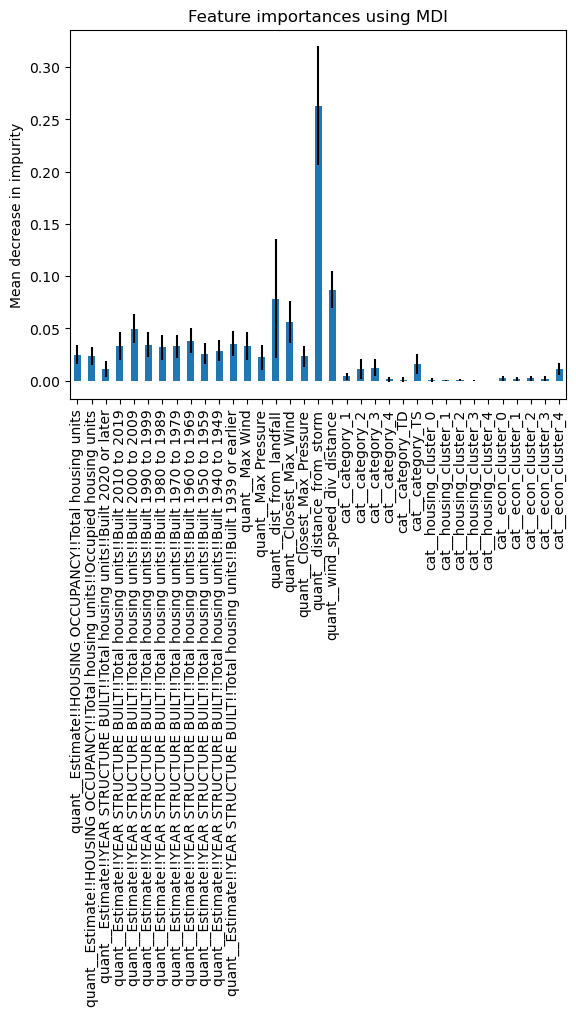

In [202]:
importances = best_model_rfr.feature_importances_
feature_names = [i for i in X__.columns]
std = np.std([tree.feature_importances_ for tree in best_model_rfr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

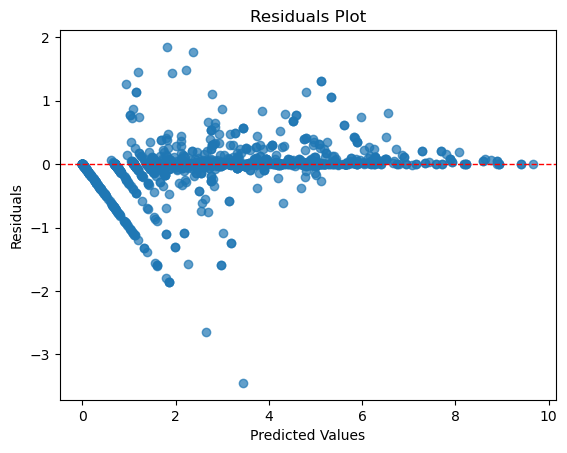

In [203]:
y_pred = best_model_rfr.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

In [85]:
X_.columns

Index(['Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
       'Max Wind', 'Max Pressure',

In [86]:
_ = X_.drop(labels=['Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units'],
       axis=1,
       )
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

_ = X_.drop(labels=[
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    ],
    axis=1,
    )
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

_ = X_.drop(labels=[
        'Max Wind',
        'Max Pressure',
        'dist_from_landfall',
    ],
    axis=1,
    )
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

_ = X_.drop(labels=[
        'category_1',
        'category_2',
        'category_3',
        'category_4',
        'category_TD',
        'category_TS',
    ],
    axis=1,
    )
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

[0.9658706218556238, 0.9709326412230403, 0.9782681010054928, 0.9696095961920819, 0.9639596391050278, 0.9716655943360483, 0.969779560438976, 0.9696237600680854, 0.964991368455596, 0.9738336565439928]
0.9698534539223965
0.004067608168407314
[0.9696681471855229, 0.9738310708826148, 0.9801288345493487, 0.9698477496101261, 0.9671376257189971, 0.9704106353486692, 0.968293974701238, 0.9682653051873013, 0.959316227288325, 0.9755847506027914]
0.9702484321074936
0.005257380048698304
[0.9633172722065289, 0.9673957852086635, 0.9763388802786297, 0.9655356941580393, 0.9601817516917973, 0.9675233078357663, 0.9658494124340075, 0.9679676689693938, 0.9644164674523042, 0.9700921571639892]
0.966861839739912
0.004100558452593321
[0.9670241334641889, 0.9704874122126086, 0.9770639579388463, 0.9661412226810343, 0.9638005512699067, 0.9713493943479623, 0.9680000366801872, 0.9683391257293659, 0.9655718397186384, 0.9710404199005803]
0.968881809394332
0.0035928119557087942


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6a6374cd-5e77-49b2-b1d3-d73b9b2f23ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>